In [7]:
import numpy as np
import torchvision
from pretrainedmodels import inceptionresnetv2
import torch
from my_modules.nsclc import NSCLCDataset
m = inceptionresnetv2(num_classes=1001, pretrained=False)
m.load_state_dict(torch.load(f'{torch.hub.get_dir()}/checkpoints/inceptionresnetv2-520b38e4.pth'))
for params in m.parameters():
    params.requires_grad = False
data = NSCLCDataset('E:/NSCLC_Data_for_ML', ['orr', 'taumean', 'boundfraction'], device='cpu',
                        label='Metastases', mask_on=True)

In [8]:
import torchinfo
torchinfo.summary(m, input_size=((64,) + tuple(data.shape)))

Layer (type:depth-idx)                        Output Shape              Param #
InceptionResNetV2                             [64, 1001]                --
├─BasicConv2d: 1-1                            [64, 32, 255, 255]        --
│    └─Conv2d: 2-1                            [64, 32, 255, 255]        (864)
│    └─BatchNorm2d: 2-2                       [64, 32, 255, 255]        (64)
│    └─ReLU: 2-3                              [64, 32, 255, 255]        --
├─BasicConv2d: 1-2                            [64, 32, 253, 253]        --
│    └─Conv2d: 2-4                            [64, 32, 253, 253]        (9,216)
│    └─BatchNorm2d: 2-5                       [64, 32, 253, 253]        (64)
│    └─ReLU: 2-6                              [64, 32, 253, 253]        --
├─BasicConv2d: 1-3                            [64, 64, 253, 253]        --
│    └─Conv2d: 2-7                            [64, 64, 253, 253]        (18,432)
│    └─BatchNorm2d: 2-8                       [64, 64, 253, 253]        (128)

In [9]:
import torchvision.transforms.v2 as tvt
data.augment()
data.normalize_channels('preset')
data.transforms = tvt.Compose([tvt.RandomVerticalFlip(p=0.25),
                               tvt.RandomHorizontalFlip(p=0.25),
                               tvt.RandomRotation(degrees=(-180, 180))])

In [10]:
def make_print_hook(layer):
    def hook(m, input, output):
        print(f'{layer}: {output.shape}')
    return hook

In [11]:
import matplotlib.pyplot as plt
def make_fig_hook(layer):
    def hook(m, input, output):
        num_channels = output.shape[1]
        fig_rows = int(np.floor(np.sqrt(num_channels)))
        fig_cols = int(np.ceil(np.sqrt(num_channels)))
        fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(20, 20))
        for r in range(fig_rows):
            for c in range(fig_cols):
                if r * c < output.shape[1]:
                    img = tvt.ToPILImage()(output[0, int(r * c)])
                    ax[r, c].imshow(img, cmap='gray')
                    ax[r, c].axis('off')
        fig.savefig(f'{layer}.png')
        plt.close('fig')
    return hook

In [ ]:
layers_of_interest = {'Stem': 'maxpool_5a',
                      'Inception': 'mixed_5b',
                      'Inception-ResNet-A': 'repeat',
                      'Reduction-A': 'mixed_6a',
                      'Inception-ResNet-B': 'repeat_1',
                      'Reduction-B': 'mixed_7a',
                      'Inception-ResNet-C': 'block8',
                      'Features': 'conv2d_7b'}

x = data[4][0]
x[torch.isnan(x)] = 0

In [16]:
img = tvt.ToPILImage()(x)
plt.imshow(img)
plt.ioff()
plt.axis('off')
plt.savefig('input.png')

In [13]:
for mod, layer in layers_of_interest.items():
    hook_handle = getattr(m, layer).register_forward_hook(make_print_hook(mod))
    hook_handle = getattr(m, layer).register_forward_hook(make_fig_hook(mod))

Stem: torch.Size([1, 192, 29, 29])
Inception: torch.Size([1, 320, 29, 29])
Inception-ResNet-A: torch.Size([1, 320, 29, 29])
Reduction-A: torch.Size([1, 1088, 14, 14])
Inception-ResNet-B: torch.Size([1, 1088, 14, 14])
Reduction-B: torch.Size([1, 2080, 6, 6])
Inception-ResNet-C: torch.Size([1, 2080, 6, 6])
Features: torch.Size([1, 1536, 6, 6])


RuntimeError: Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small

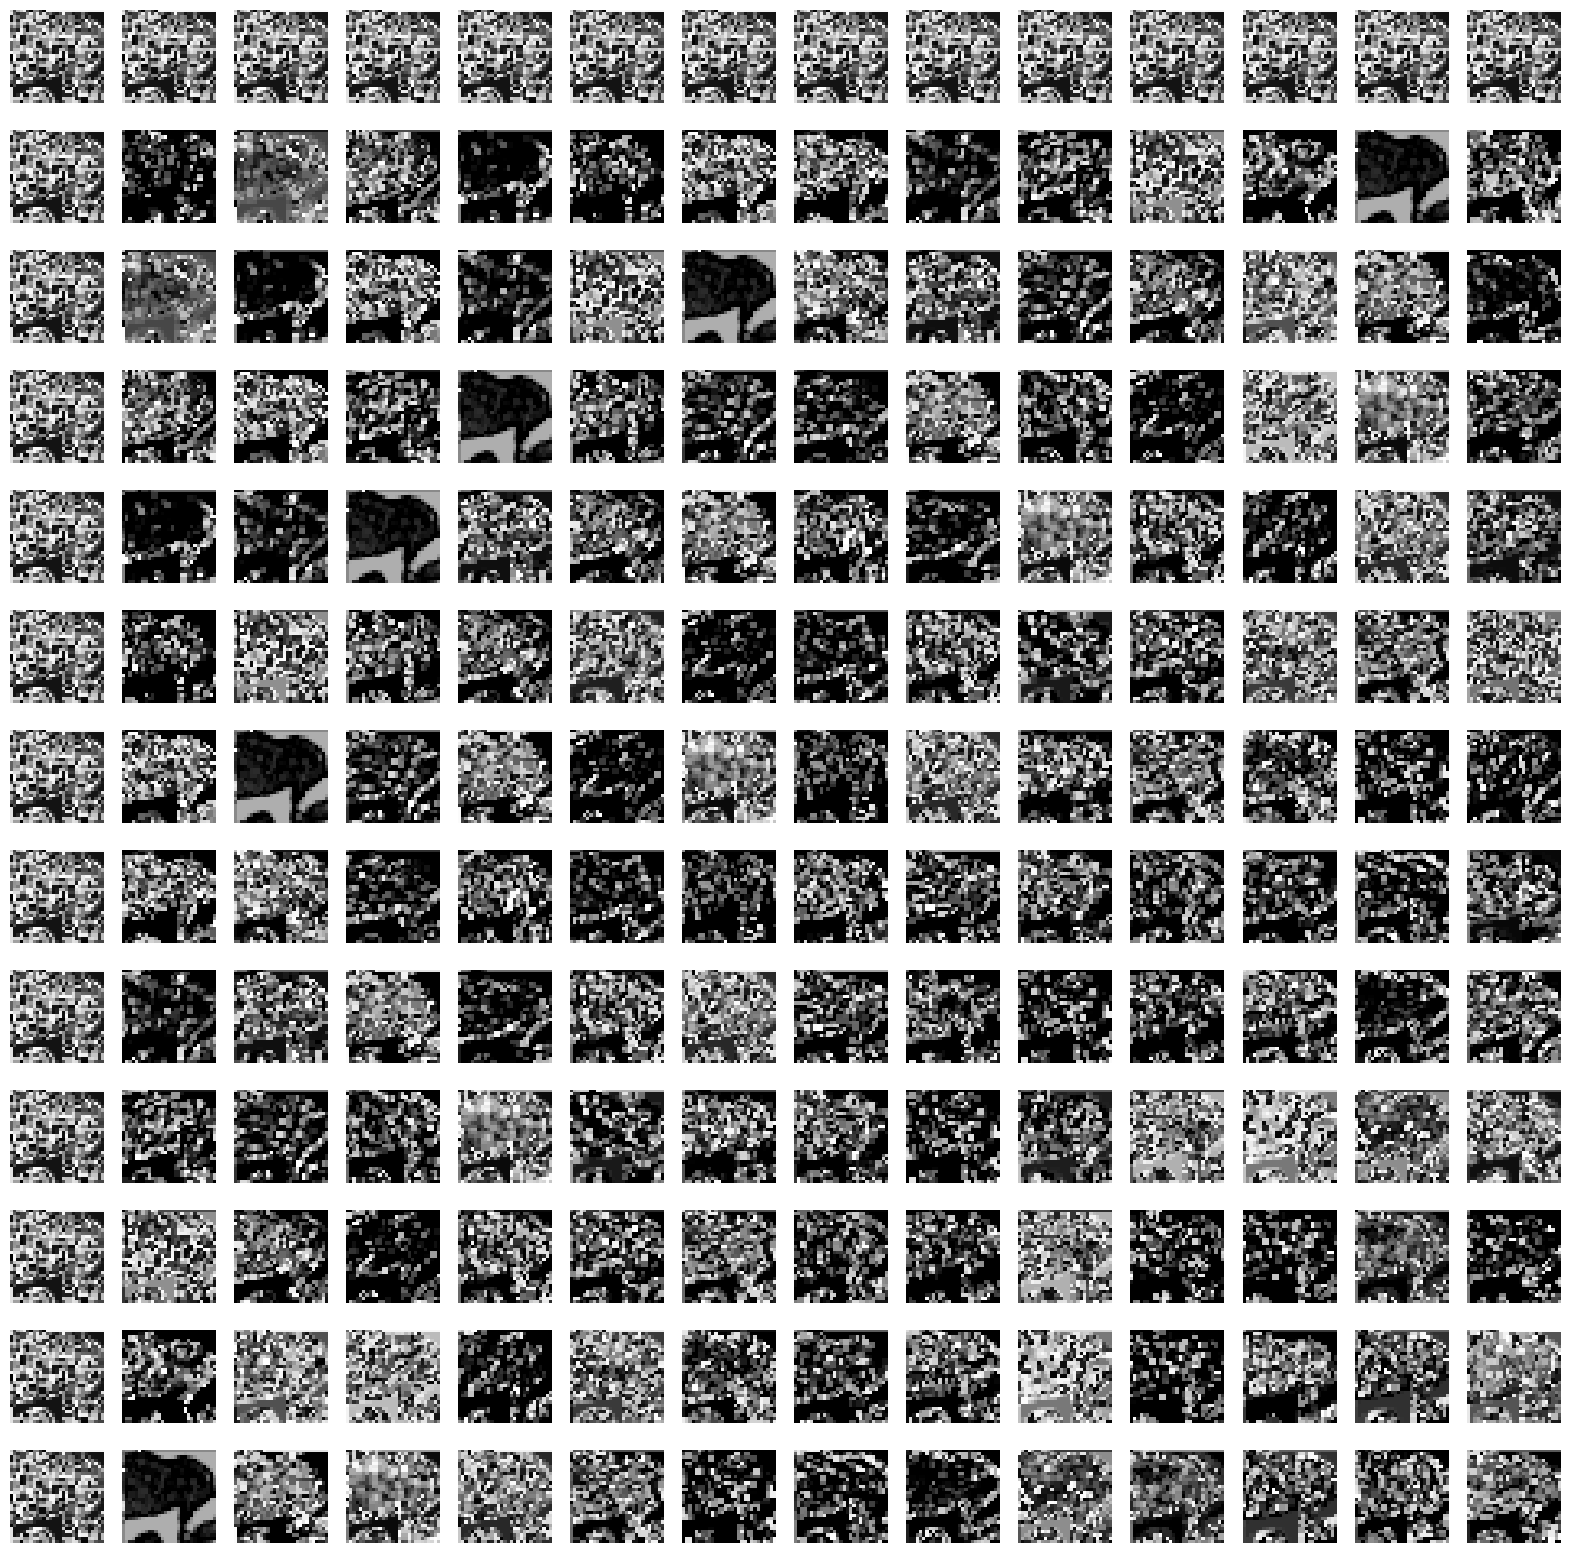

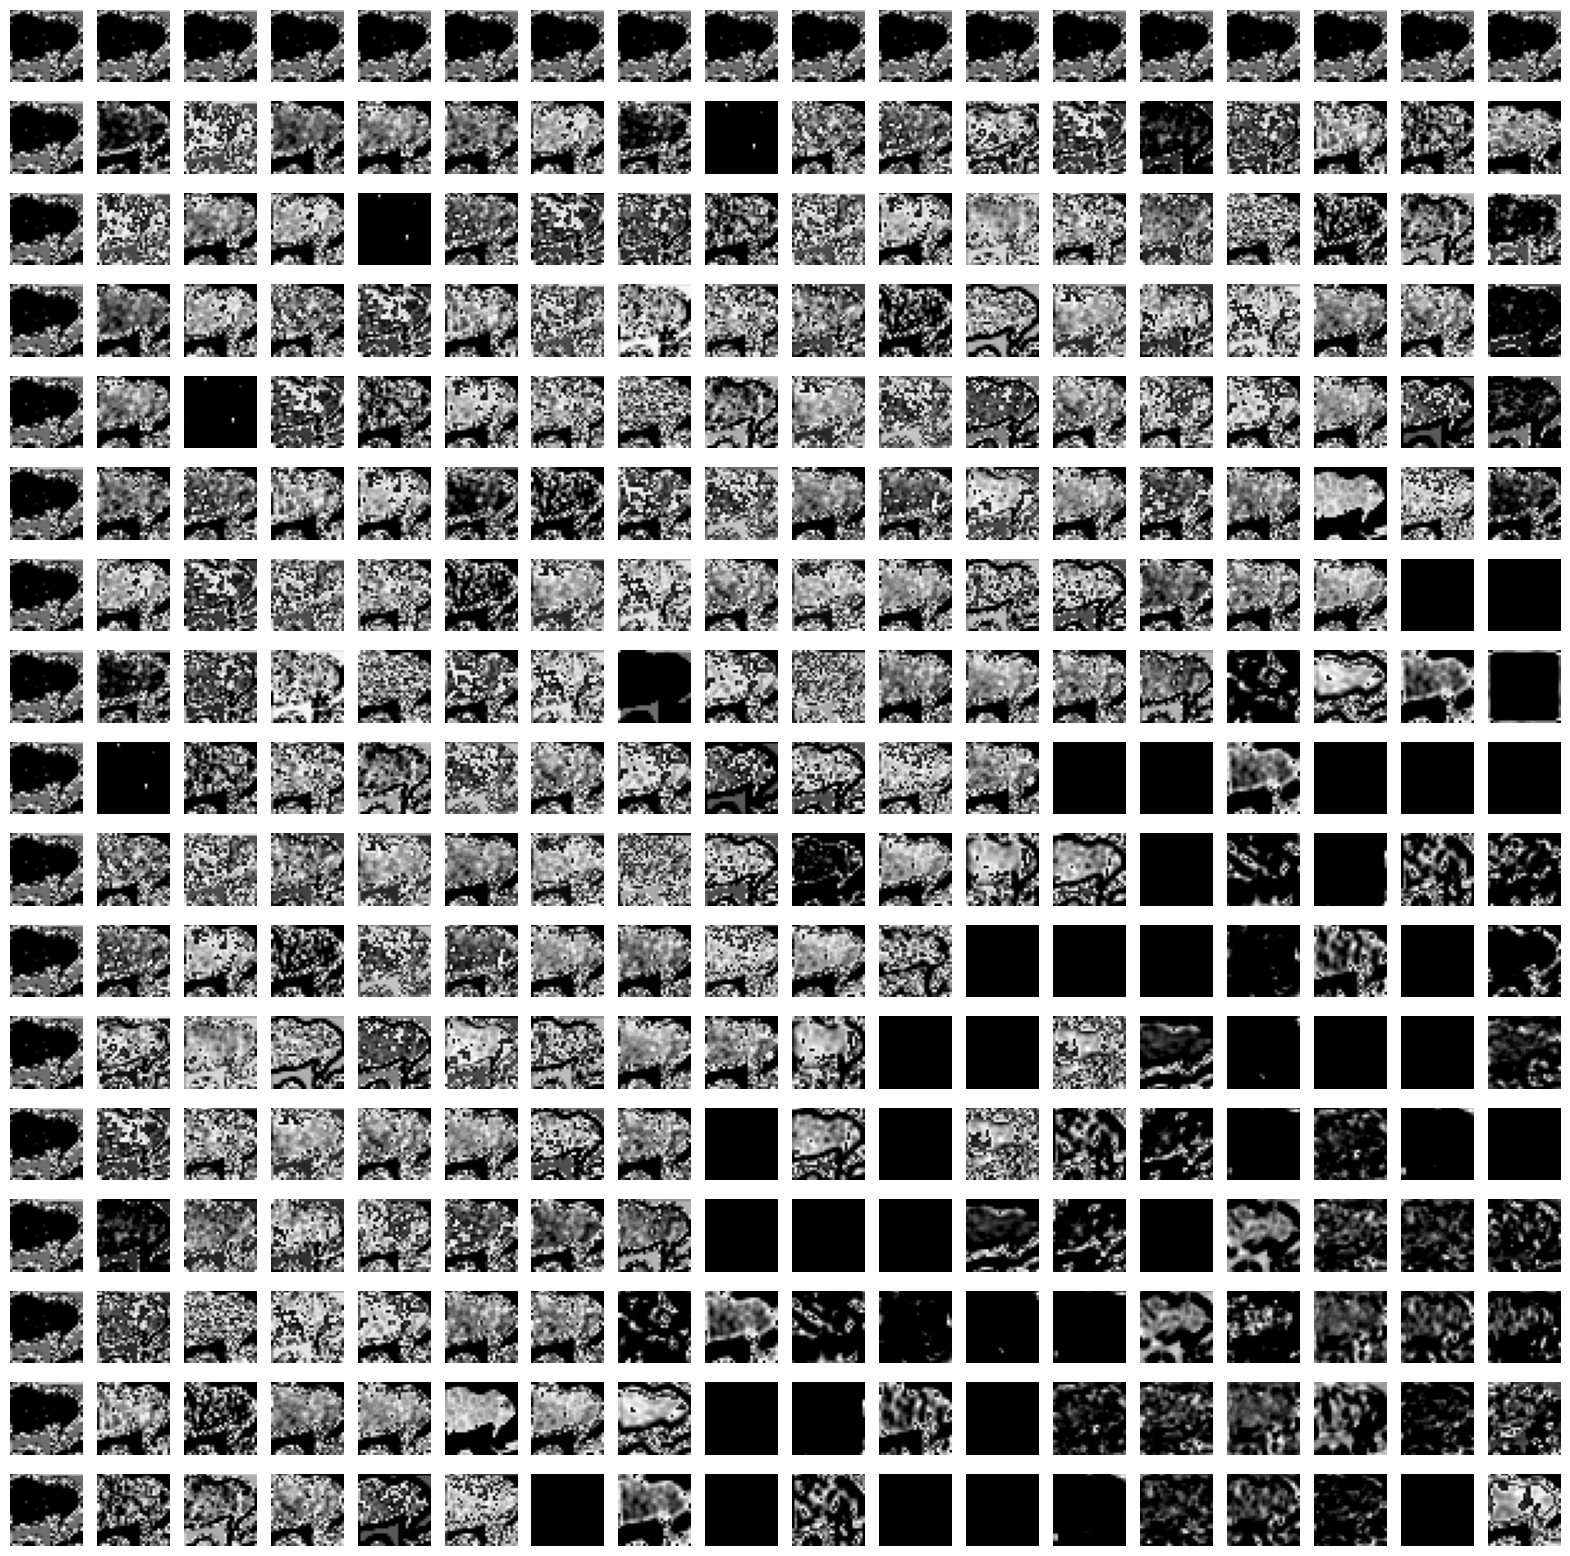

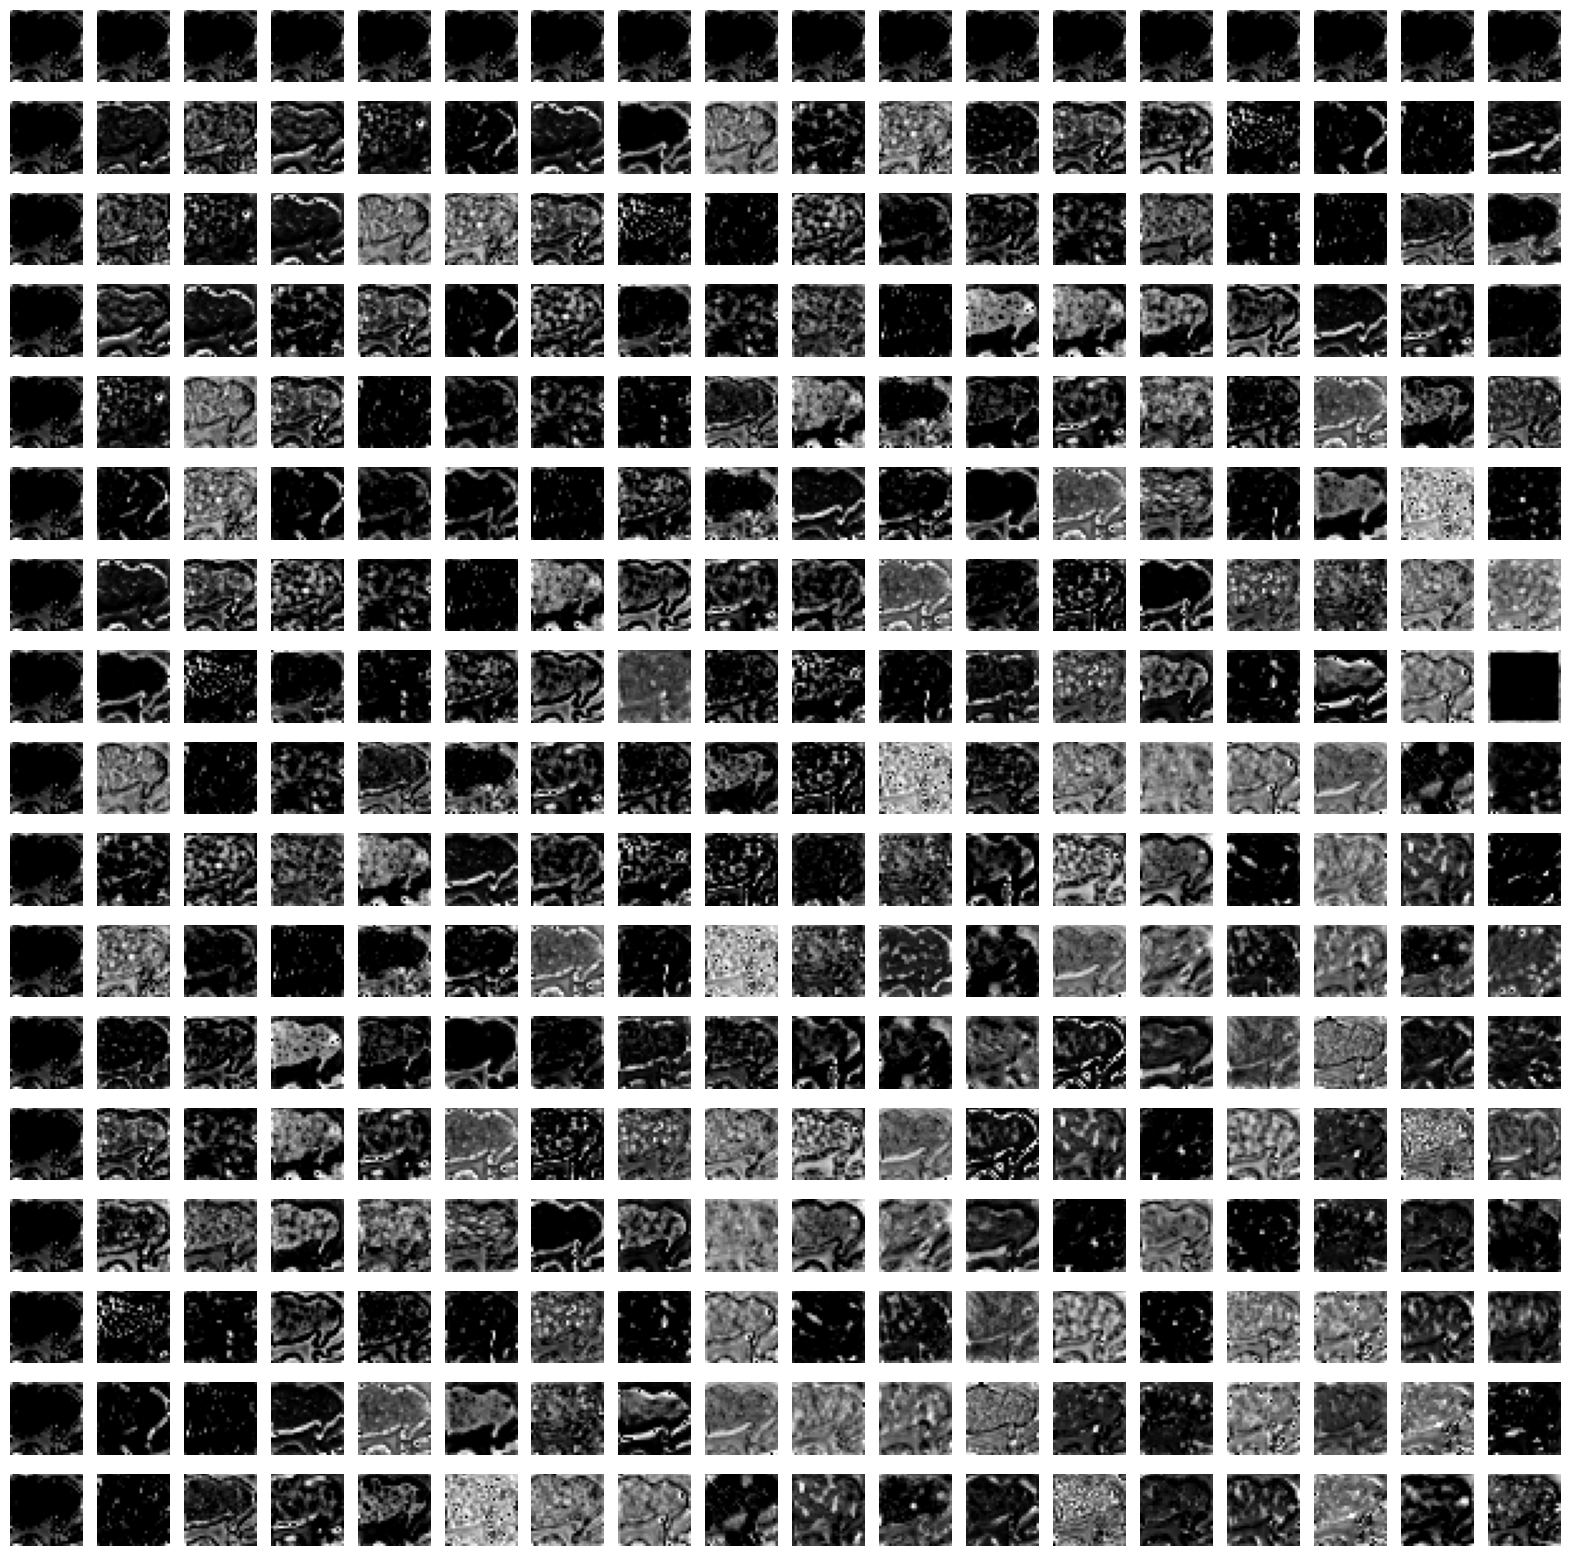

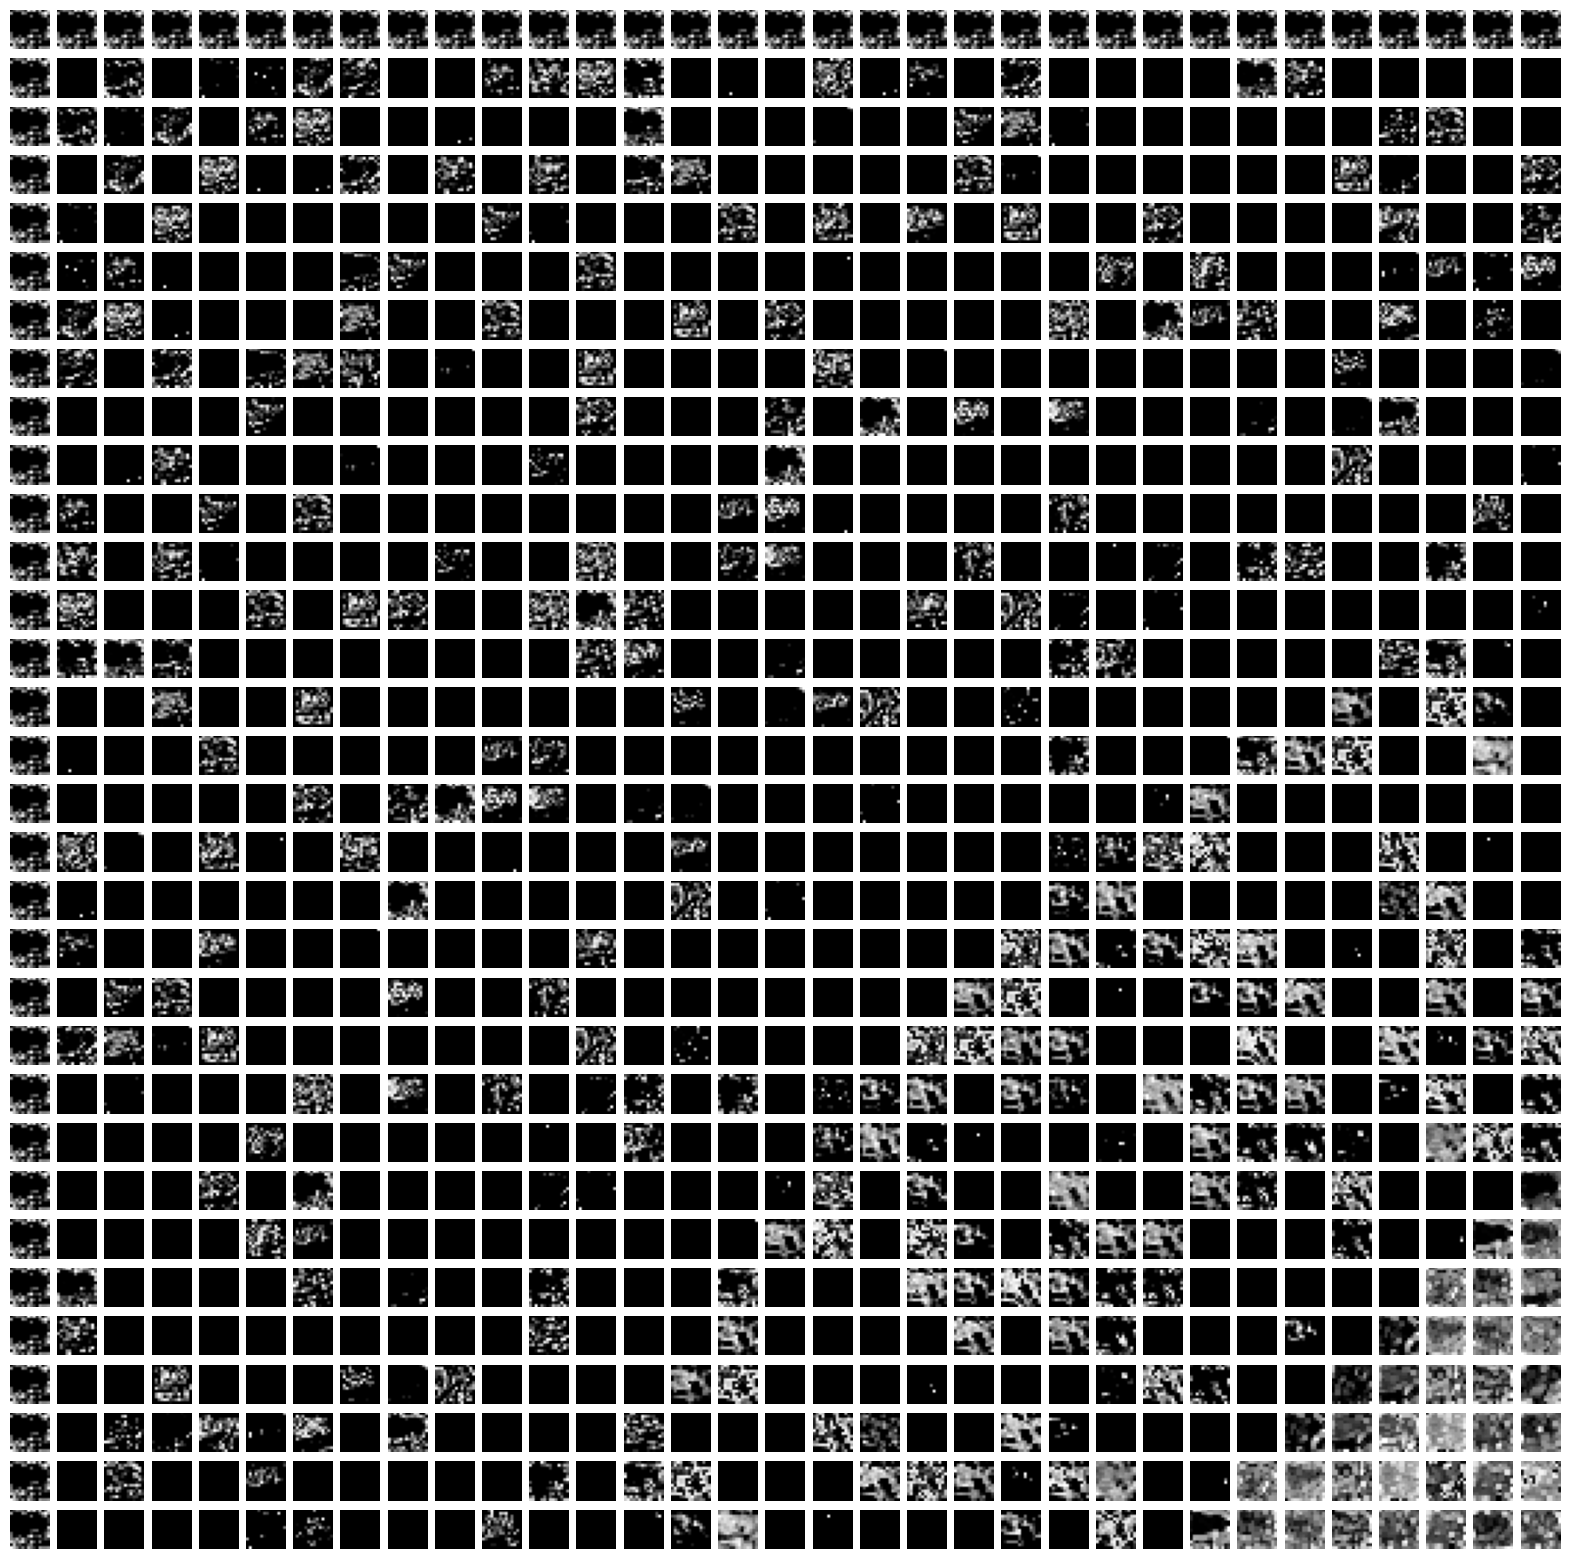

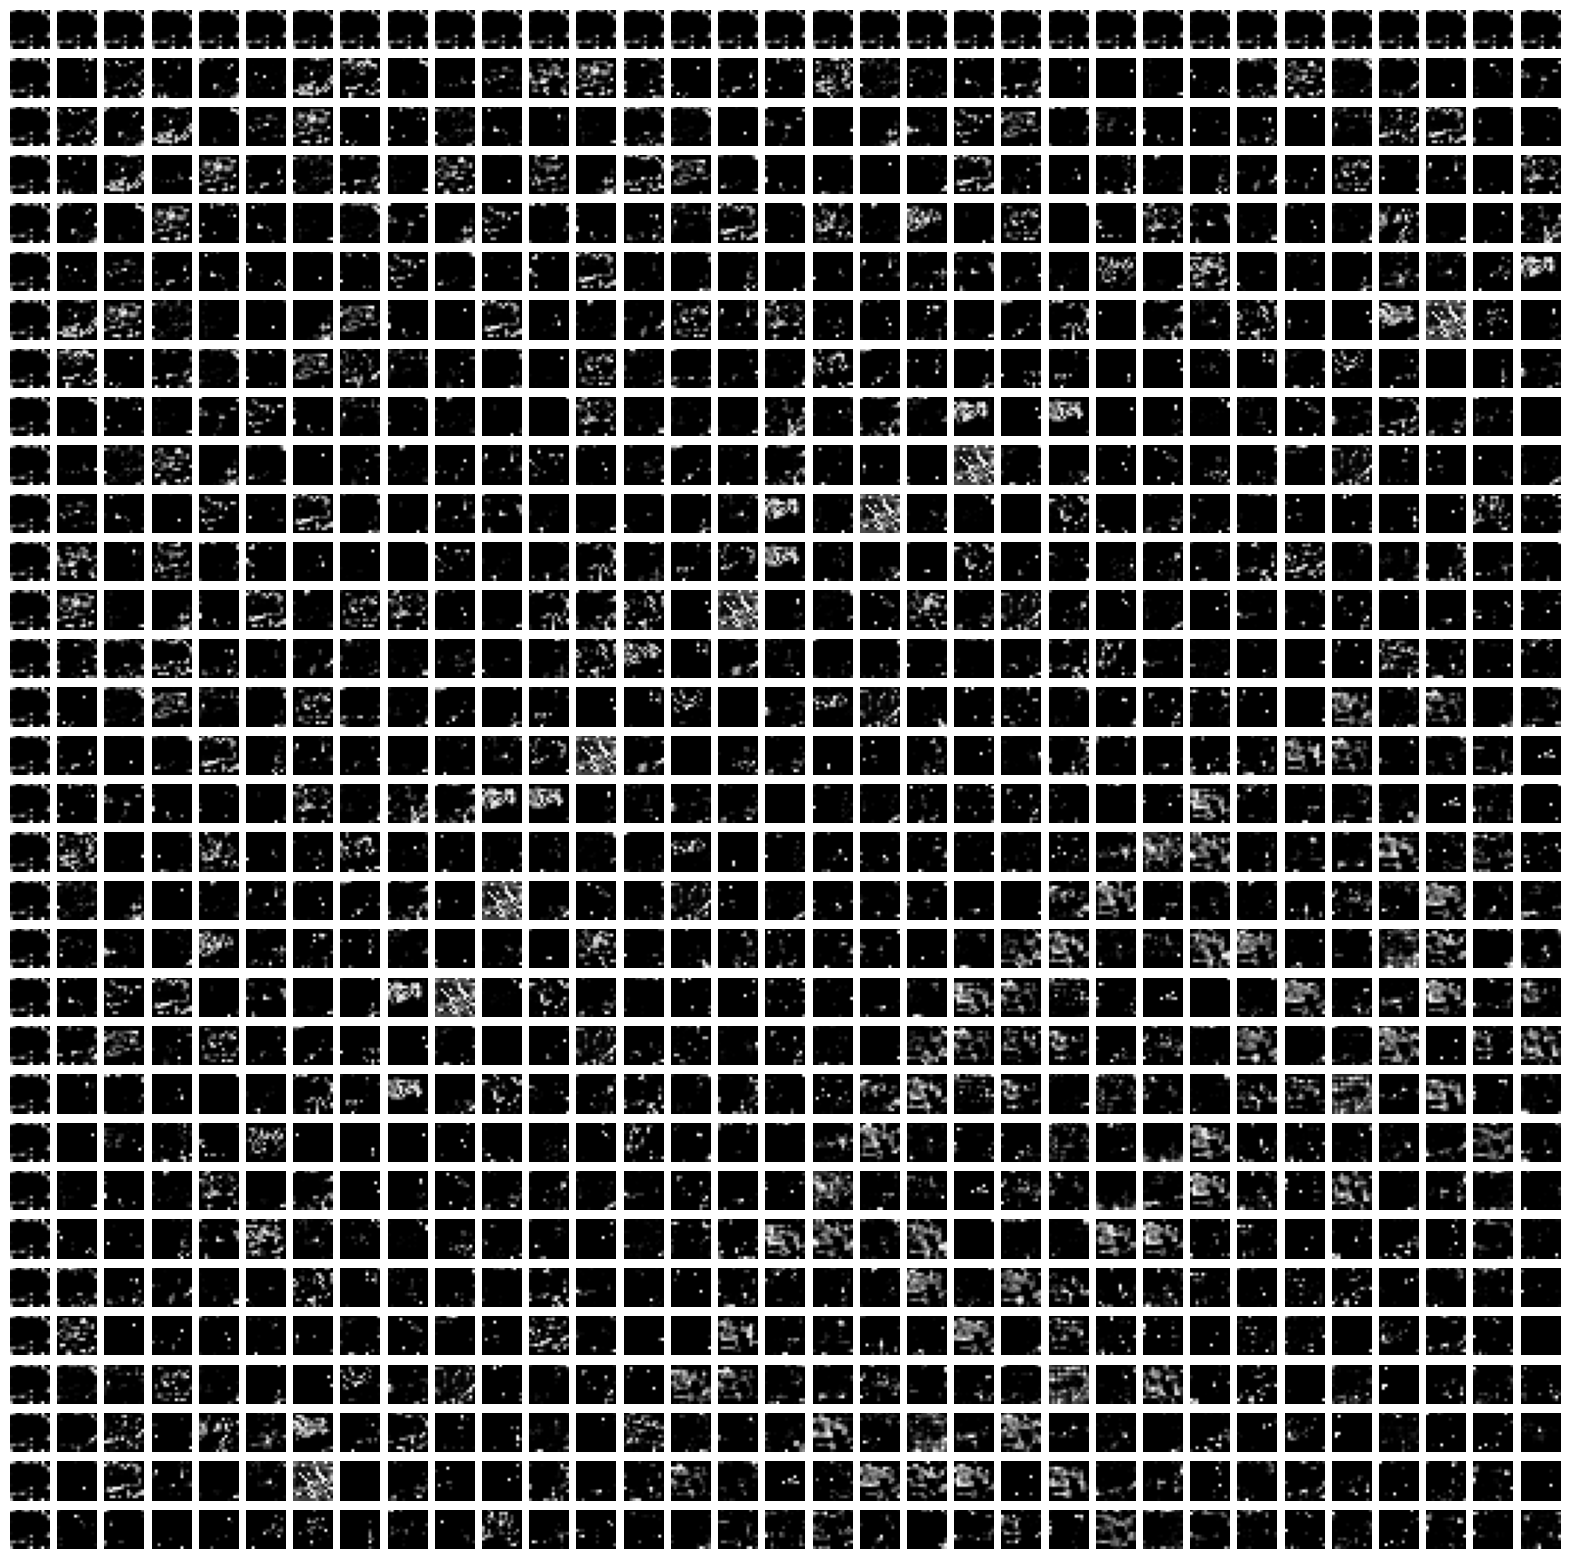

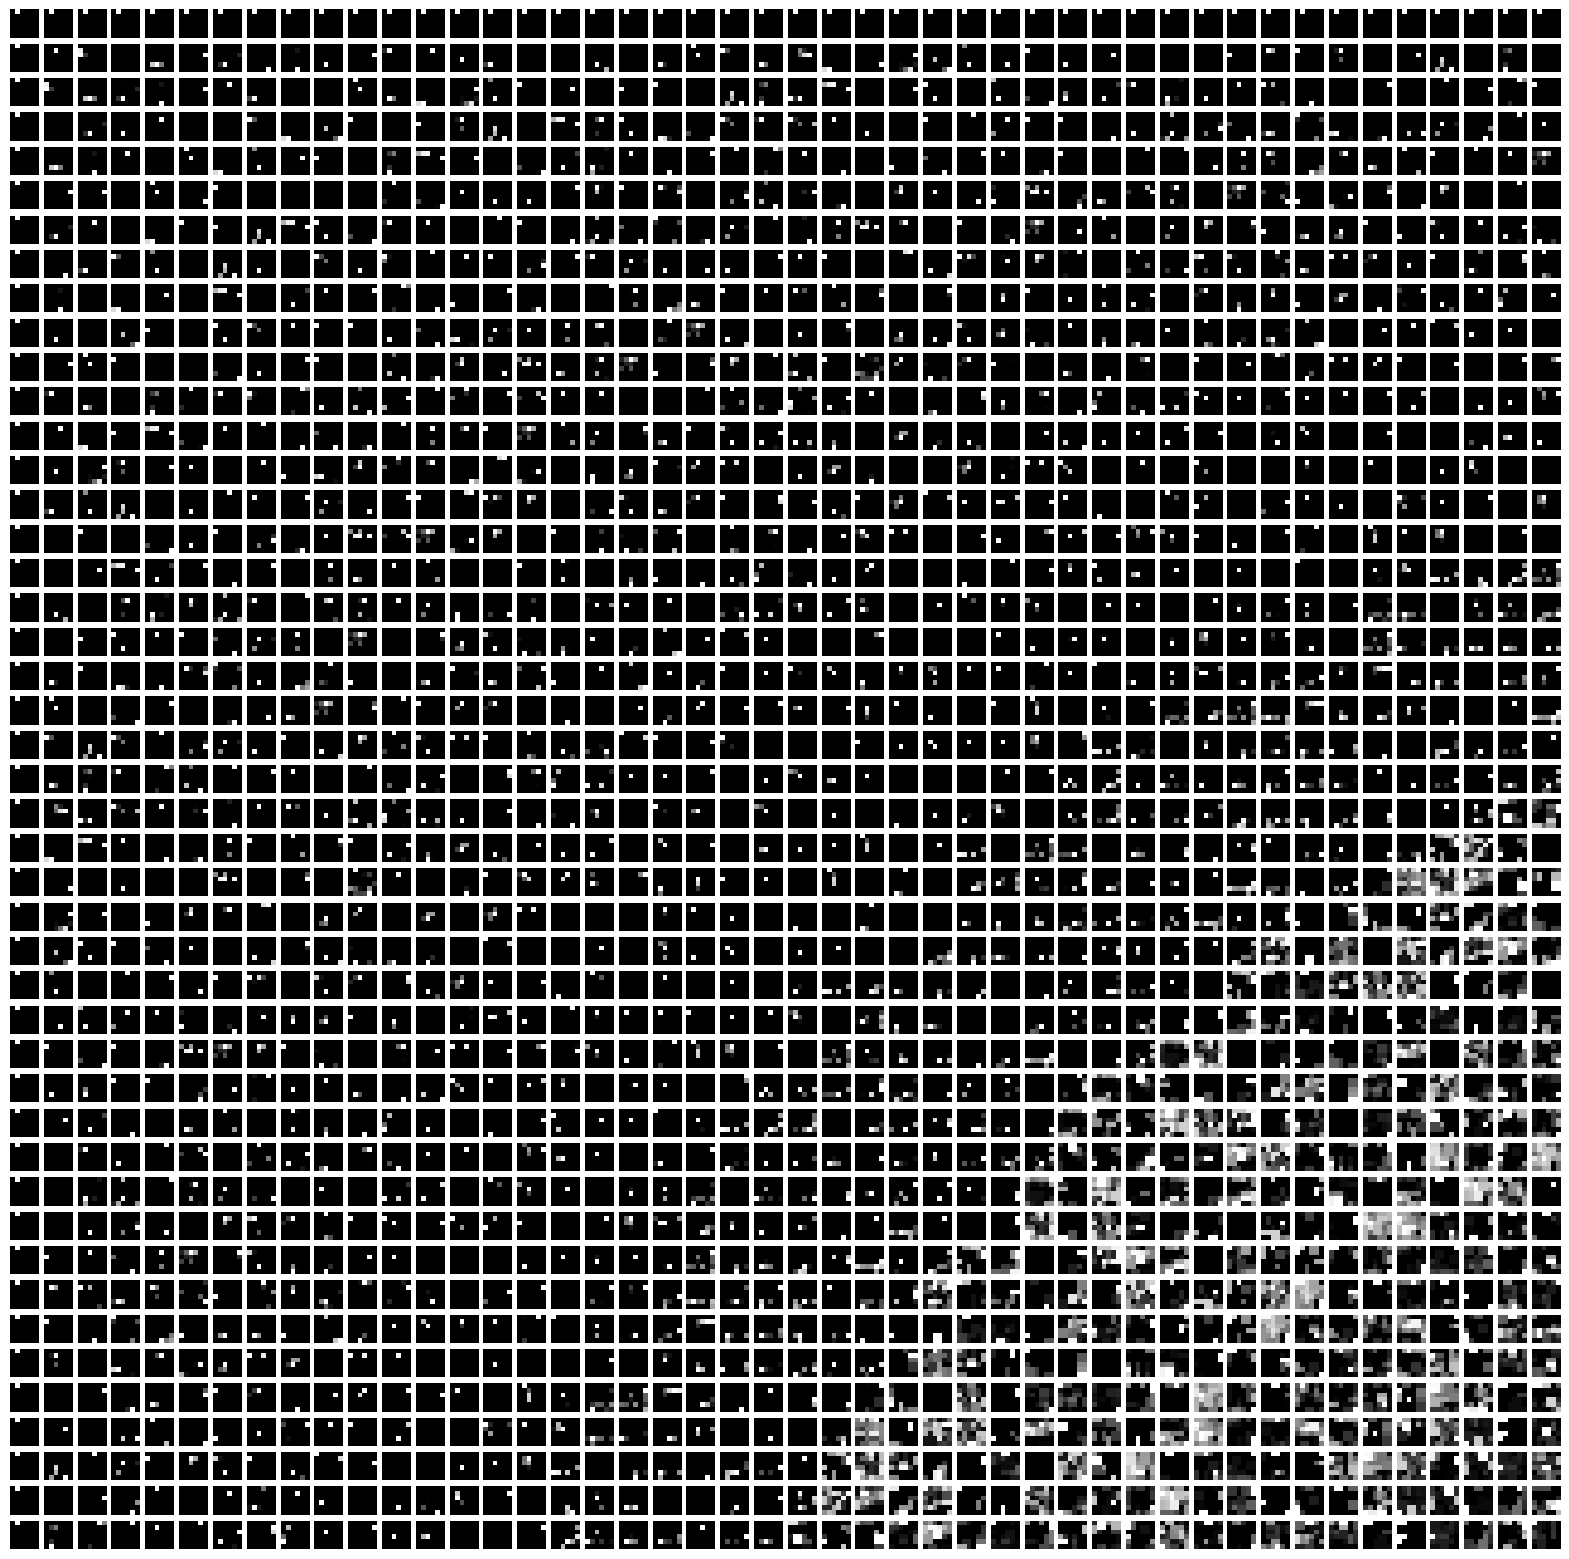

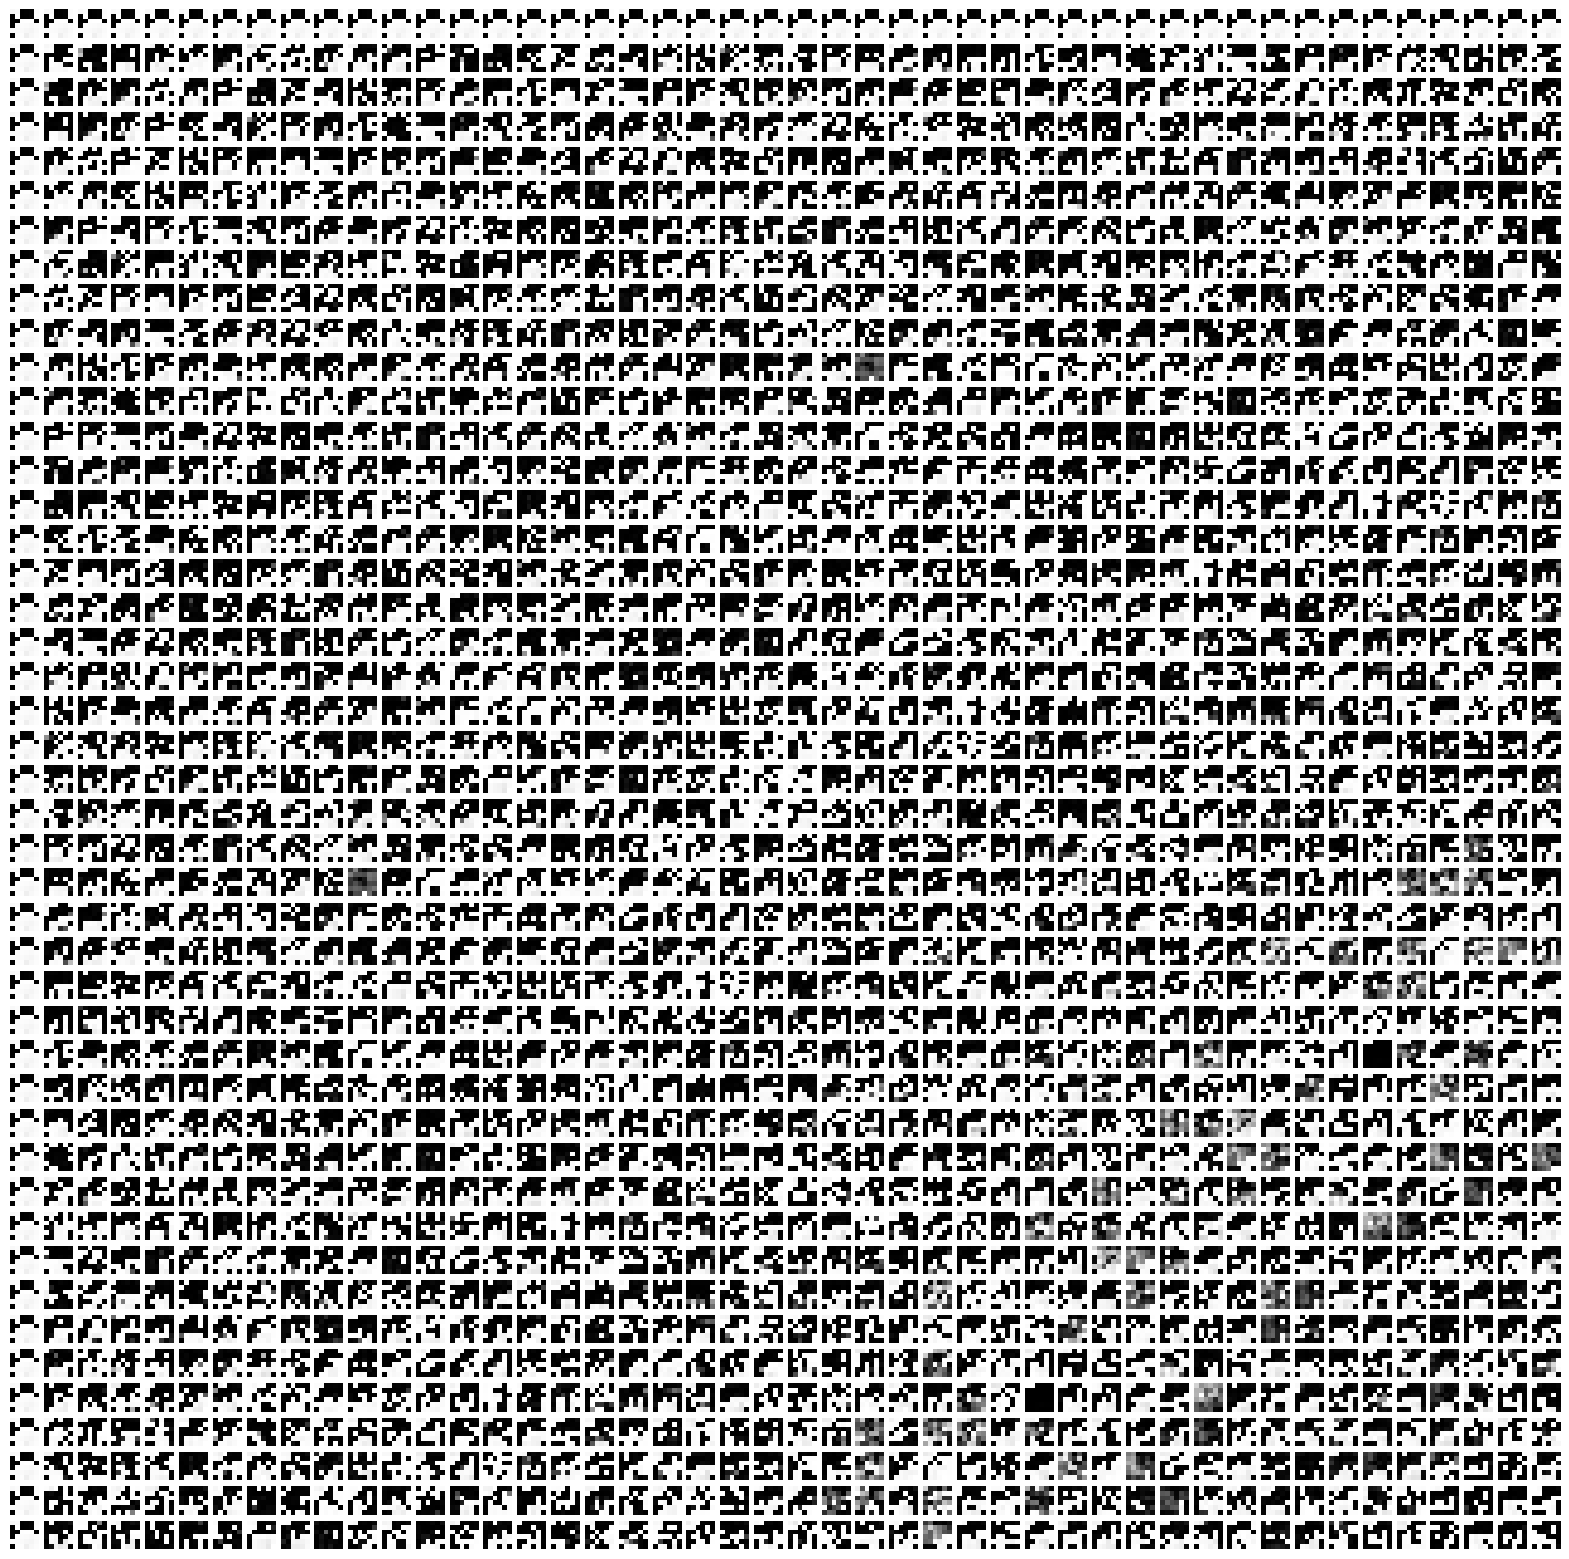

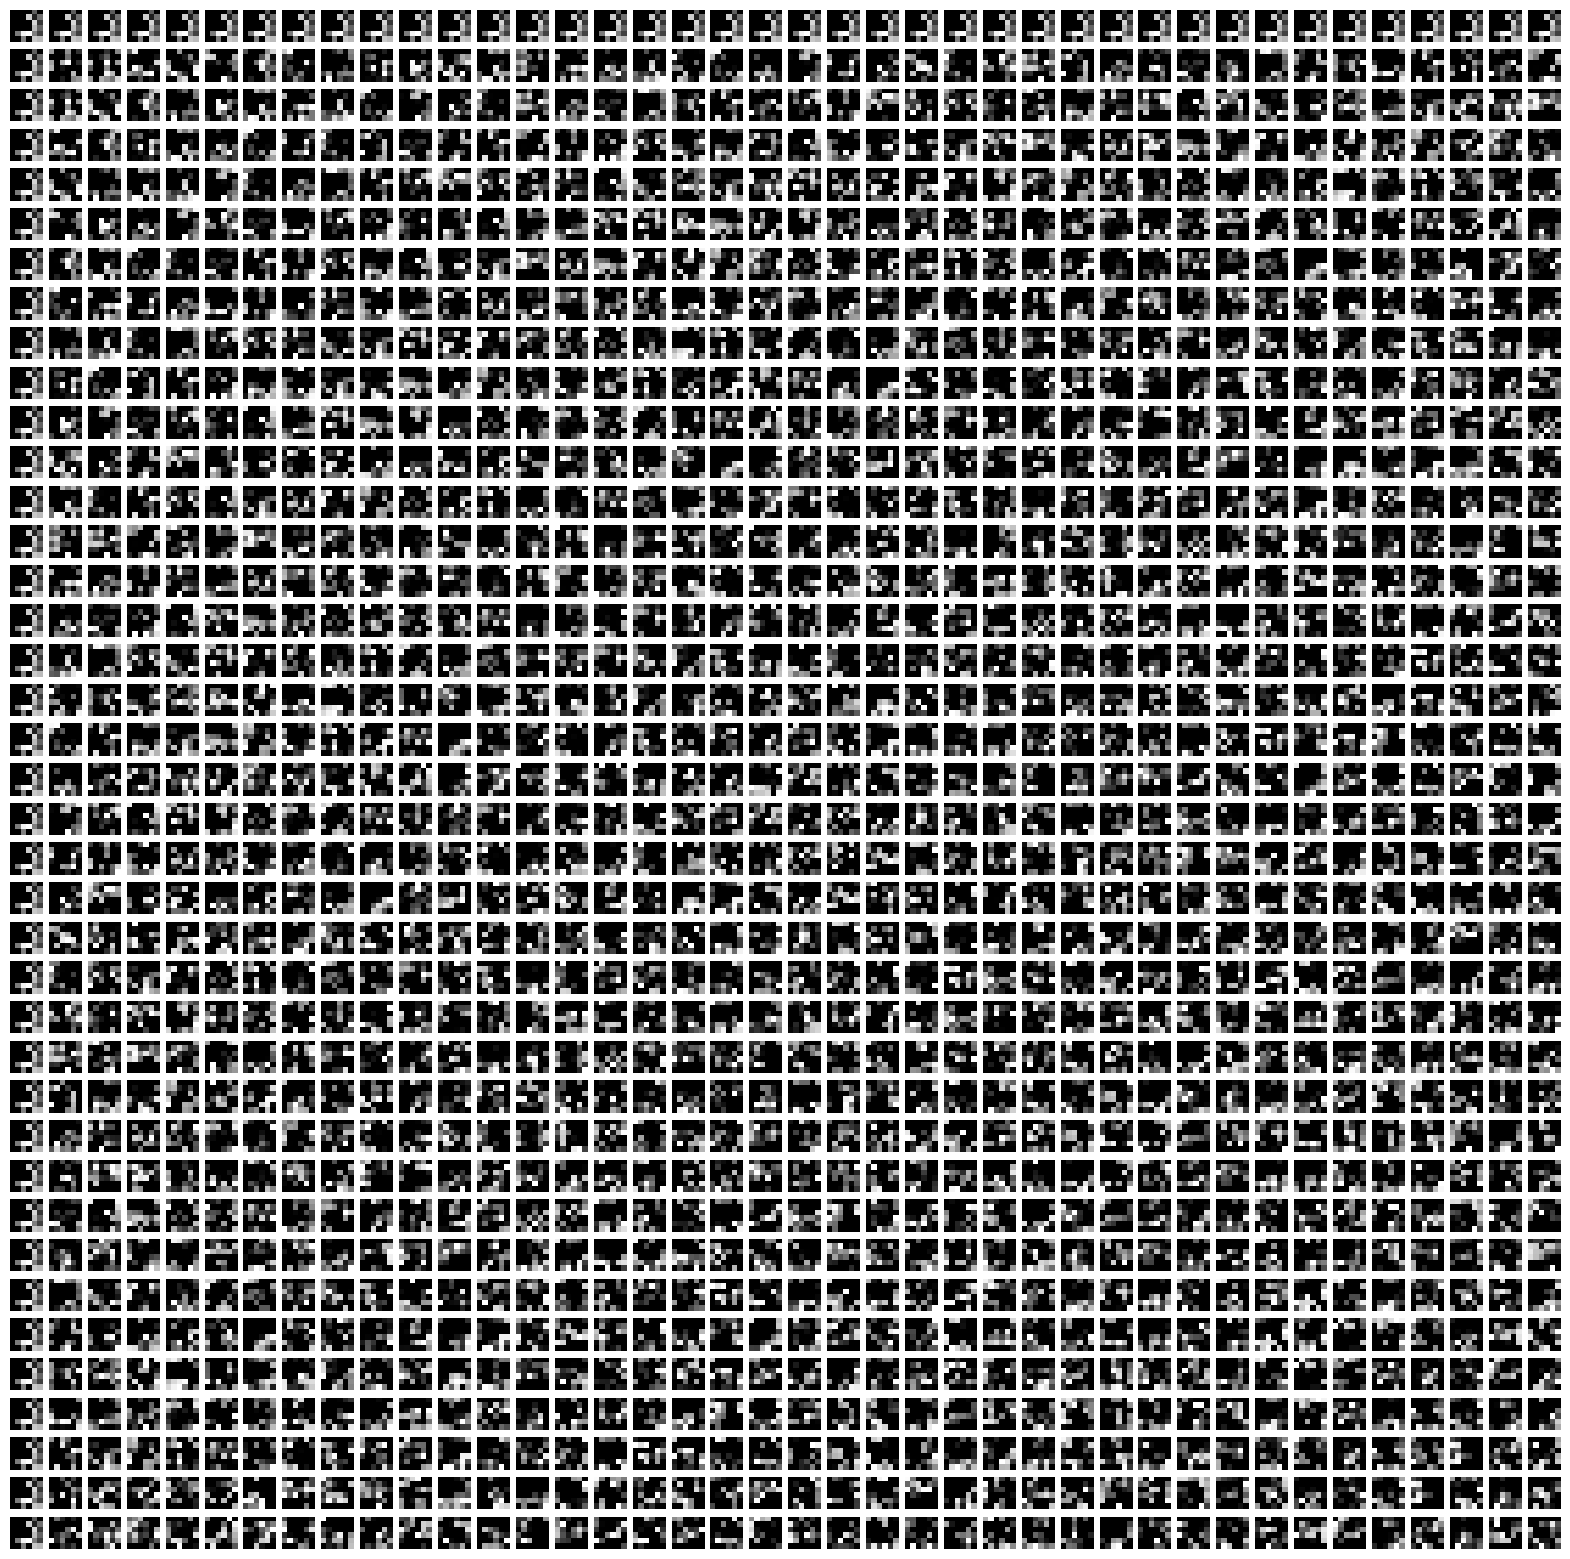

In [14]:
y = m(x.unsqueeze(0))

In [15]:
import torchvision
for name, filters in m.named_parameters(recurse=True):
    try:
        n,c,h,w = filters.shape
        filters = filters[:, 0, :, :].unsqueeze(1) if c != 3 else filters
        
        rows = np.min((filters.shape[0] // 9, 64))
        grid = torchvision.utils.make_grid(filters, nrow=9, normalize=True, padding=1)
        plt.figure(figsize = (9,9))
        plt.imshow(grid.numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.ioff()
        plt.savefig(f'{name}_filters.png')
        plt.close()
    except Exception as e:
        pass